# 3D (2D + t) FNO Training Predictions

**Authors**: Xuesong (Cedar) Ma, Bernard Chang, and Masa Prodanovic

**Last Updated**: Apr. 30, 2025

---
This notebook demonstrates the inference workflow of a 3D Fourier Neural Operator (FNO) model, where the input is structured as 2D spatial data over time (2D + t). 

**Contents:**
- Data loading
- FNO model definition and configuration
- Evaluation on test data
- Visualization of predictions vs. ground truth

---

## Import packages

In [9]:
# System packages
import os
import glob
import sys
sys.path.append('..')

# ML packages
import lightning as pl
from network.FNO3d import FNO3D

# Data processing
from dataloading import mcf_dataloader, split_indices
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from matplotlib import gridspec
import imageio.v2 as imageio
from IPython.display import Image, display
from tqdm import tqdm

# Configuration
from omegaconf import OmegaConf
cfg = OmegaConf.load("config.yaml")

# Set the seed for reproducibility
pl.seed_everything(cfg.seed)

Seed set to 189031465


189031465

## Load Test Dataset

Here, we load the subset of the data reserved for testing. Inputs contain 8 initial timesteps of a mean curvature flow simulation and outputs are the next 16 time steps.

In [6]:
n_samples = 160
split = [0.6, 0.2, 0.2]
image_ids = np.random.randint(low=0, high=159, size=(n_samples,))
_, _, test_ids = split_indices(image_ids, split, seed=cfg.seed)
_, _, test_loader = mcf_dataloader(image_ids,
                                   data_path="mc_flow_data.h5",
                                   t_in=cfg.T_in,
                                   t_out=cfg.T_out,
                                   seed=cfg.seed,
                                   split=split,
                                   num_workers=2,
                                   pin_memory=True)

## Load the trained model

This is a pretrained model that is identical to the one saved from the training script. You can replace this with your own trained model if needed.

In [8]:
# Load the trained model
model_dir = f"../saved_models/mcf/checkpoints"
model_loc = glob.glob(f'{model_dir}/*val*.ckpt')[0]
print(f'Loading {model_loc}')

# Instantiate an FNO3D model from the checkpoint
model = FNO3D.load_from_checkpoint(model_loc)

# Set the model to evaluation mode
model.eval()

Loading ../saved_models/mcf/checkpoints\epoch=79-val_loss=0.06.ckpt


FNO3D(
  (p): Linear(in_features=11, out_features=24, bias=True)
  (fno_blocks): ModuleList(
    (0-3): 4 x FourierBlock3D(
      (spectral_conv): SpectralConv3d()
      (w): Conv3d(24, 24, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    )
  )
  (q): LP(
    (lp1): Linear(in_features=24, out_features=96, bias=True)
    (lp2): Linear(in_features=96, out_features=1, bias=True)
  )
)

## Make Test Predictions

In the following cells, we make predictions on the test dataset and visualize the predictions. To better visualize the model performance, we compute the average radial spectral energy in addition to the predicted time series evolution.

### Spectral Analysis

* Perform 2D FFT on reference & predicted pressure fields at each time step.
* Compute the energy spectrum $E(k_x, k_y) = |\hat{f}(k_x, k_y)|^2$
* Compute radial average to get 1D spectrum (for easier comparison)

In [11]:
def compute_energy_spectrum(field):
    """
    Compute the energy spectrum of a 2D field using Fast Fourier Transform (FFT).

    This function calculates the energy spectrum by performing a 2D FFT on the input field,
    shifting the zero frequency component to the center, and computing the squared magnitude
    of the shifted FFT.

    Parameters:
        field (torch.Tensor): A 2D tensor of shape [H, W] representing the input field.

    Returns:
        numpy.ndarray: A 2D numpy array of shape [H, W] representing the energy spectrum of the input field.
    """
    fft2 = np.fft.fft2(field, axes=(0, 1))
    fft2_shifted = np.fft.fftshift(fft2)
    energy = np.abs(fft2_shifted) ** 2
    return energy


def radial_average(energy):
    """
    Compute the radial average of a 2D energy spectrum.

    This function computes the average energy at each radial distance from the center 
    of a 2D field. It is commonly used to reduce a 2D power or energy spectrum to a 
    1D profile based on isotropic radial bins.


    Parameters:
        energy (numpy.ndarray): A 2D tensor of shape [H, W] representing the energy spectrum.

    Returns:
        numpy.ndarray: A 1D numpy array where each element contains the average energy at the corresponding radial distance from the center.
    """
    H, W = energy.shape
    center = (H // 2, W // 2)

    Y, X = np.ogrid[:H, :W]
    r = np.sqrt((X - center[1])**2 + (Y - center[0])**2).astype(np.int32)

    r_max = r.max()
    spectrum = np.bincount(r.ravel(), weights=energy.ravel()) / np.bincount(r.ravel())
    return spectrum[:r_max]


def plot_predictions(prediction, T_in):
    """
    Generate visualizations and an animated GIF comparing predicted and ground truth MCF evolution over time.

    For each time step, this function plots the:
        - Ground truth contour
        - Predicted contour
        - Relative error heatmap
        - Radial spectral energy comparison

    Each time step is assembled them into an animated GIF.

    Parameters:
        prediction (dict): Output dictionary from lightning's `predict_step` containing:
            - "y" (torch.Tensor): Ground truth
            - "yhat" (torch.Tensor): Model prediction
        T_in (int): Total number of initial time steps input into the model.

    Returns:
        None
    """
    y_true = prediction["y"][0, :, :, :].squeeze().cpu().numpy()
    y_pred = prediction["yhat"][0, :, :, :].squeeze().cpu().numpy()

    os.makedirs("frames", exist_ok=True)
    filenames = []

    for j in tqdm(range(int(cfg.T_out))):
        plt.close('all')
        fig = plt.figure(figsize=(12, 8))
        gs = gridspec.GridSpec(2, 3, figure=fig)

        # Subplot for True MCF
        ax0 = fig.add_subplot(gs[0, 0])
        ax0.set_title('Ground Truth')
        ax0.contour(y_true[..., j], levels=[0], colors='b')
        ax0.set_aspect('equal')
        ax0.grid('off')

        # Subplot for Predicted MCF
        ax1 = fig.add_subplot(gs[0, 1])
        ax1.set_title('Predicted')
        ax1.contour(y_pred[..., j], levels=[0], colors='b')
        ax1.set_aspect('equal')
        ax1.grid('off')

        # Subplot for Relative Error
        y_rel_err = np.abs(y_true[..., j] - y_pred[..., j]) / np.abs(y_true[..., j])
        y_rel_err[y_rel_err == np.inf] = 0
        y_rel_err[y_rel_err == -np.inf] = 0
        y_rel_err[y_rel_err == np.nan] = 0
        
        ax2 = fig.add_subplot(gs[0, 2])
        ax2.set_title('Relative Error')
        cax2 = ax2.imshow(y_rel_err, cmap='plasma', vmin=0, vmax=0.15)
        ax2.invert_yaxis()
        ax2.grid('off')

        fig.colorbar(cax2, ax=ax2, fraction=0.046, pad=0.04)

        # Subplot for Spectral Comparison
        ax3 = fig.add_subplot(gs[1, 1:3])
        ax3.set_title('Radial Spectral Energy Comparison')
        # Compute 2D energy spectrum
        true_energy = compute_energy_spectrum(y_true[..., j])
        pred_energy = compute_energy_spectrum(y_pred[..., j])
        # Compute radial average of energy spectrum
        true_spectrum = radial_average(true_energy)
        pred_spectrum = radial_average(pred_energy)

        ax3.loglog(true_spectrum, label='Ground Truth')
        ax3.loglog(pred_spectrum, label='Prediction')
        ax3.set_xlabel('Frequency (radial wavenumber)')
        ax3.set_ylabel('Spectral Energy')
        ax3.legend()
        ax3.grid(True, which='both', ls='--')

        fig.suptitle(f"Time step {T_in + j}")

        # Adjust layout to avoid overlap
        plt.tight_layout()

        fname = f"frames/frame_{T_in + j:03d}.png"
        plt.savefig(fname, bbox_inches='tight')
        filenames.append(fname)
        plt.close()

    # --- Build the GIF ---
    gif_path = "mean_curvature_flow.gif"
    images = [imageio.imread(fname) for fname in filenames]
    imageio.mimsave(gif_path, images, fps=5, loop=0)

    # Optional: clean up frame files
    for f in filenames:
        os.remove(f)

    # --- Display the GIF in Jupyter ---
    display(Image(filename=gif_path))
    

The following cell generates the predictions on the test dataset.

In [12]:
# Initialize the Lightning trainer
trainer = pl.Trainer(logger=False,
                     enable_checkpointing=False)
# Make predictions on the test dataset using the trained model
predictions = trainer.predict(model, dataloaders=test_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\ProgramData\anaconda3\envs\ms-fno\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting: |          | 0/? [00:00<?, ?it/s]

The following cell visualizes the predictions for a specific sample ID. Move the slider to visualize predictions for different samples.

100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


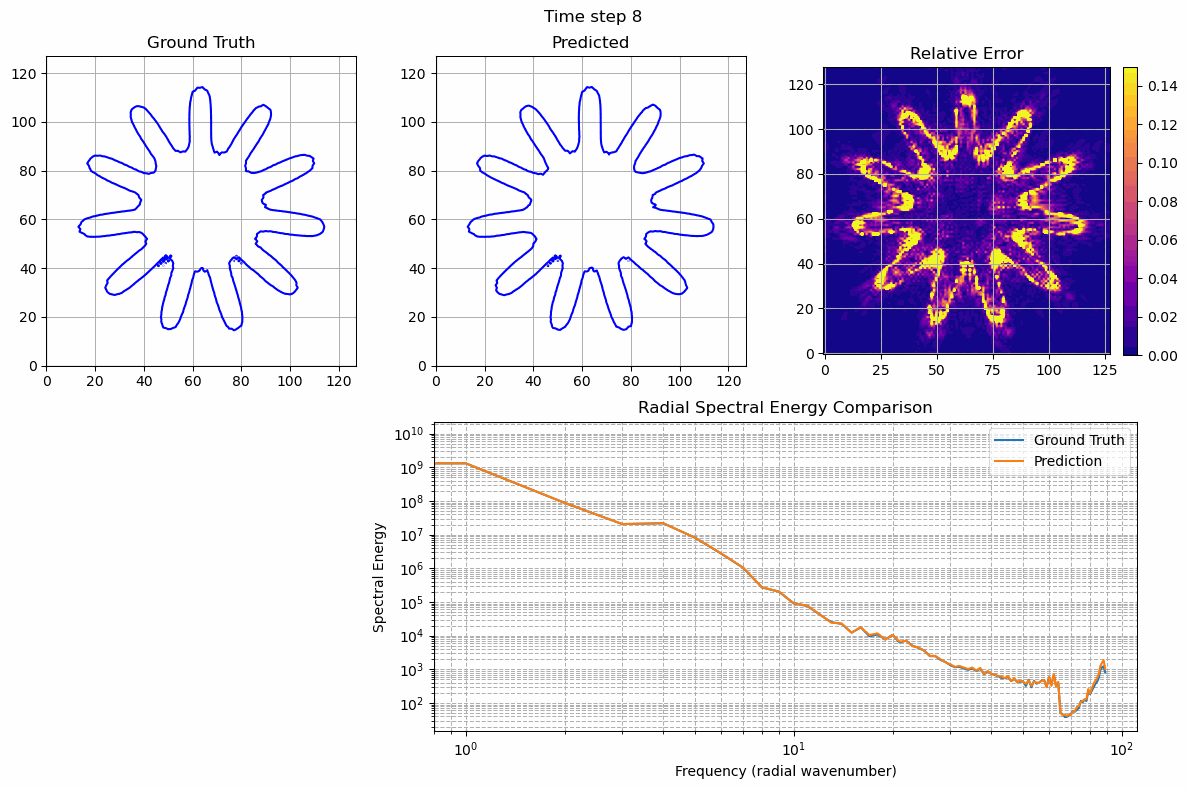

In [ ]:
idx = 5
plot_predictions(predictions[idx], cfg.T_in)
